In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, accuracy_score


# Inputs
source_csv = '/home/andris/GitHub/data/churn_prediction/teacher_time_series.csv'

# Reading and cleaning data

Read the csv data, manipulate and prepare for ML.

In [95]:
# Reading csv data
df = pd.read_csv(source_csv)


In [96]:
# Create a new column that discretises the time into seperate time legs

dt = 30*24*3600
df['event_leg'] = np.floor((pd.to_datetime(df['date_created']) - pd.to_datetime(df['registration_date'])).dt.total_seconds()/dt)

def prepare_df(df,date_feature, group_array,start_date,end_date):

    # Convert to datetime format
    df[date_feature] = pd.to_datetime(df[date_feature])

    # Select data from dates according to start_date and end_date
    df = df[df[date_feature]>= pd.to_datetime(start_date)]
    df = df[df[date_feature]<= pd.to_datetime(end_date)]

    # Group according to categories
    df_grp = df.groupby(group_array).count();

    # Unpack the indices into columns
    df_grp = df_grp.xs(date_feature, axis=1, drop_level=True)
    df_grp = df_grp.unstack().fillna(0)
  
    # Return the dataframe
    return df_grp

# Group and create a new multi index dataframe  

start_date = '2014-08-01'
end_date = '2017-08-01'

df_grp = prepare_df(df,'date_created',['user_id','event_leg','event_type'],start_date,end_date)
df_grp.head()

event_type                                                    add_assig  \
user_id                                            event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0             0.0   
                                                    0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0             0.0   
                                                    1.0             0.0   

event_type                                                    add_custom_assig  \
user_id                                            event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                    0.0   
                                                    0.0                    0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                    0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                    0.0   
                                                    1.0                    0.0   

event_type                                                    add_user  \
user_id                                            event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0            0.0   
                                                    0.0            0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0            0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0            0.0   
                                                    1.0            0.0   

event_type                                                    attempt  \
user_id                                            event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0           4.0   
                                                    0.0           3.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0           4.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0           8.0   
                                                    1.0           5.0   

event_type                                                    create_group  \
user_id                                            event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                0.0   
                                                    0.0                0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                0.0   
                                                    1.0                0.0   

event_type                                                    view_assig_prog  
user_id                                            event_leg                   
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                   0.0  
                                                    0.0                   0.0  
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                   0.0  
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                   0.0  
                                                    1.0                   0.0

In [97]:
## Add the events of event_leg -1 to 0

# Change the -1 event to 0
df_new = df_grp[df_grp.index.get_level_values(1)<0].reset_index()
df_new['event_leg'] = 0

# Add the dataframes together
df = df_grp.add(df_new.set_index(['user_id','event_leg']),fill_value=0)

# Removing event_leg = -1
df = df[df.index.get_level_values(1)>= 0]

df.head()


event_type                                                    add_assig  \
user_id                                            event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0              0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0              0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0              0.0   
                                                   1.0              0.0   
                                                   4.0              0.0   

event_type                                                    add_custom_assig  \
user_id                                            event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                     0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                     0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   4.0                     0.0   

event_type                                                    add_user  \
user_id                                            event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0             0.0   
                                                   1.0             0.0   
                                                   4.0             0.0   

event_type                                                    attempt  \
user_id                                            event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0            7.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0            4.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0            8.0   
                                                   1.0            5.0   
                                                   4.0           16.0   

event_type                                                    create_group  \
user_id                                            event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                 0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                 0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   4.0                 0.0   

event_type                                                    view_assig_prog  
user_id                                            event_leg                   
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                    0.0  
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                    0.0  
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                    0.0  
                                                   1.0                    0.0  
                                                   4.0                    0.0

## Arranging target and train variables for predicting churn

Pick a month to predict user churn, here anyone whose last month was in month 0


In [98]:
last_month = 0;

# Find users that have churned
plot_churn = df.reset_index().groupby('user_id')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Display the dataframe
df_lm.head(10)

,event_type,add_assig,add_custom_assig,add_user,attempt,create_group,view_assig_prog
user_id,event_leg,,,,,,
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,0.0,0.0,0.0,0.0,7.0,0.0,0.0
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d1663a47a8a9f1937f,0.0,0.0,0.0,0.0,4.0,0.0,0.0
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,8.0,0.0,0.0
001ee4c077e3972984ebddee5d8928ea3be07031025d61888f2f4c58f61179ee,0.0,1.0,1.0,1.0,6.0,0.0,4.0
0037979dda749ad521e81ac59c594706d4ab73f53003793016e877be4ce41efb,0.0,0.0,2.0,12.0,1.0,1.0,4.0
0068f32c6dcbbdfa08c1b9cedc8d10b13f370725691cfdeb40e99c6c81d6056d,0.0,1.0,0.0,0.0,26.0,1.0,0.0
006a28f9870a964816db69d1bb9dda8be0cac871af2fdfc3c303179023a2e299,0.0,0.0,0.0,0.0,4.0,0.0,0.0
0074b02fc56ee657538a30d3471450dbdee09d0db79cb5f3d2931ea52b8e82d0,0.0,0.0,1.0,1.0,13.0,1.0,2.0
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de85b0764b714db2ba90,0.0,0.0,3.0,10.0,60.0,1.0,4.0


(2760, 6)
2760


(array([ 1244.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1516.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

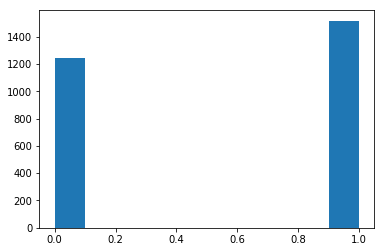

In [153]:
# Provide variables
X = df_lm.reset_index().set_index('user_id').drop('event_leg',axis=1)
y = np.array(label)

# Scaling the features
scaler = StandardScaler()

X_trf = scaler.fit_transform(X)
X = X_trf

# Checking their length
print(X.shape)
print(len(y))

plt.hist(y)

In [141]:
# Splitting the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [142]:
# Testing function

def test_classifier(X,y, clf_class,n_fold,**kwargs):
    
    # Construct a kfolds object
    kf = KFold(n_splits=n_fold,shuffle=True)
    y_checks = np.zeros(len(y))
    
    # Iterate through folds
    score = [];
    for train_index, test_index in kf.split(y):
        
        # Training classifier
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        
        # Predicting values and testing
        y_pred = clf.predict(X_test)
        score.append([accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),
                      recall_score(y_test,y_pred)])
        
        # Predicted values from cross-validation
        y_checks[test_index] = y_pred

    df_score = pd.DataFrame(score, columns=['Accuracy', 'Precision','Recall'])
    df_score.loc['mean'] = df_score.mean()
    
    return df_score, y_checks, clf


             precision    recall  f1-score   support

          0       0.66      0.37      0.47       264
          1       0.59      0.82      0.69       288

avg / total       0.62      0.61      0.58       552

0.632825652357


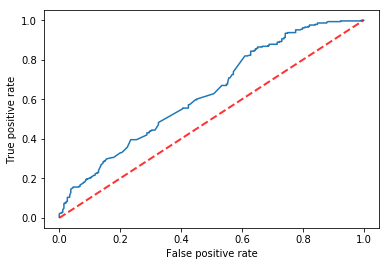

In [162]:
clf = RF(n_estimators=1000)
#clf = LR()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print(classification_report(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test,y_score[:,1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

print(roc_auc_score(y_test,y_score[:,1]))



([array([ 149.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  403.]),
  array([ 264.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  288.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

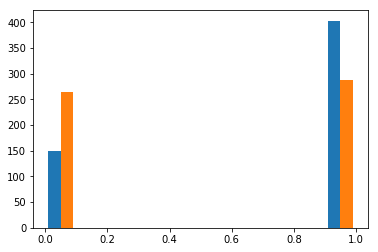

In [164]:
plt.hist([y_pred,y_test],histtype='bar')

In [161]:
df_score, y_pred, clf = test_classifier(X,y,RF, 5, n_estimators=1000)
print(df_score)

      Accuracy  Precision    Recall
0     0.695652   0.685230  0.881620
1     0.652174   0.643979  0.814570
2     0.648551   0.642674  0.819672
3     0.628623   0.596859  0.817204
4     0.670290   0.665796  0.825243
mean  0.659058   0.646908  0.831662
